In [3]:
# Restore FashionNet architecture using tf-graph in ./graph and this code sample
# dataset available at https://github.com/zalandoresearch/fashion-mnist

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from IPython.display import Image

from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('fashion-mnist/data/fashion', one_hot=True)

Extracting fashion-mnist/data/fashion/train-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz


![title](fashion-mnist/visualization/zalando-mnist-sprite.png)

In [5]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

In [6]:
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1],
                        padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME', name=name)

In [7]:
class FasionNet:
    def __init__(self, max_iter=10000):
        self.max_iter = max_iter
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.x = tf.placeholder(tf.float32, shape=(None, 784), name="X")
            self.y_ = tf.placeholder(tf.float32, shape=(None, 10), name="y")
    
    def _create_layer1(self):
        with tf.name_scope("layer1"):
            W_conv1 = weight_variable((5, 5, 1, 32), name="conv_weights_lay_1")
            b_conv1 = bias_variable((32,), name="conv_bias_lay_1")
            x_image = tf.reshape(self.x, [-1, 28, 28, 1], name="img_reshape_lay_1")
            h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, name="relu_lay_1")
            self.h_pool1 = max_pool_2x2(h_conv1, name="pool_lay_1")
    
    def _create_layer2(self):
        with tf.name_scope("layer2"):
            W_conv2 = weight_variable((5, 5, 32, 64), name="conv_weights_lay_2")
            b_conv2 = bias_variable((64,), name="conv_bias_lay_2")

            h_conv2 = tf.nn.relu(conv2d(self.h_pool1, W_conv2) + b_conv2, name="relu_lay_2")
            h_pool2 = max_pool_2x2(h_conv2, name="pool_lay_2")

            W_fc1 = weight_variable((3136, 1024), name="weight_var_lay_2")
            b_fc1 = bias_variable((1024, ), name="bias_var_lay_2")

            h_pool2_flat = tf.reshape(h_pool2, [-1, 3136], name="flat_pool_2")
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name="relu_lay_2")

            self.keep_prob = tf.placeholder(tf.float32, name="keep_prob_lay_2")
            h_fc1_drop = tf.nn.dropout(h_fc1, self.keep_prob, name="dropour_lay_2")

            W_fc2 = weight_variable(shape=(1024, 10), name="weight_var2_lay_2")
            b_fc2 = bias_variable(shape=(10,), name="bias_var2_lay_2")

            self.y_conv = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2, name='conv_lay_2')
            
    def _create_loss(self):
        with tf.name_scope("loss"):
            self.cross_entropy = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels=self.y_, logits=self.y_conv))
            
    def _create_optimizer(self):
        with tf.name_scope("optimizer"):
            self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
            
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cross_entropy)
            correct_prediction = tf.equal(tf.argmax(self.y_conv, 1), tf.argmax(self.y_, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    def build_graph(self):
        self._create_placeholders()
        self._create_layer1()
        self._create_layer2()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()
    
    def train_model(self):
        losses = np.zeros(self.max_iter//100)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            summary_writer = tf.summary.FileWriter('graphs', sess.graph)
            for i in tqdm_notebook(range(self.max_iter)):
                batch = mnist.train.next_batch(50)
                if i % 100 == 0:
                    train_accuracy = self.accuracy.eval(feed_dict={
                        self.x: batch[0], self.y_: batch[1], self.keep_prob: 1.0})
                    losses[i//100] = train_accuracy
#                     print('step %d, training accuracy %g' % (i, train_accuracy))
                _, summary_str = sess.run([self.train_step, self.summary], 
                                          feed_dict={self.x: batch[0], self.y_: batch[1], self.keep_prob: 0.5})
                summary_writer.add_summary(summary_str, i)
                # I can't calculate overall accuracy because my GPU doesnt have enough memory lol
#             print('test accuracy {}'.format(self.accuracy.eval(feed_dict={self.x: mnist.test.images, self.y_: mnist.test.labels, self.keep_prob: 1})))
        plt.figure(figsize=(15,10))
        plt.plot(np.arange(1, losses.shape[0] + 1)*100, losses)
        
        plt.ylabel('Train accuracy')
        plt.xlabel('Train iteration')

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

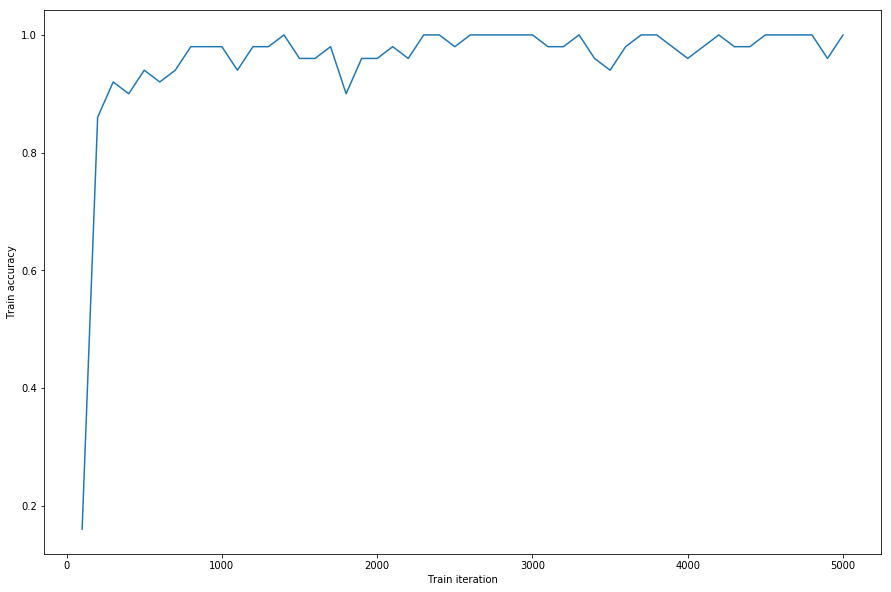

In [8]:
fn = FasionNet(max_iter=5000)
fn.build_graph()
fn.train_model()